# Instance Segmentation via Training Mask RCNN on Custom Dataset

This notebook is intended to generally explain how the code works and how to implement this project specifically; keep that in mind that this is not a beginner-friendly tutorial, so you need at least know about concepts of deep learning, segmentation, and convolutional neural network models. Also, you can find more information about the dataset that I used and the Mask-RCNN library in the `README.md` file from the Github repository.

## Loading necessary libraries

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import time
import skimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# ignore warnings to make outputs clearer
import warnings
warnings.filterwarnings('ignore')

## Check if GPU accelerator is working

The cell below is optional, and you can skip it; I'm using TensorFlow-GPU to train this model. It took about 40 minutes to run on my computer (CPU: Core i7-7700, GPU: Nvidia GTX-1060). of course, you can train the model on your CPU, which takes a bit longer.

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import Mask-RCNN and setting up the directories

Setting up the root directory helps you reduce redundancy and make the code cleaner, Also Importing essay tools from the Mask-RCNN model, remember that they have some dependencies that you need to install as well.

In [3]:
ROOT_DIR = '../Semantic-Segmentation'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist.'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

As I mentioned in the `README.md` file, this model uses pre-trained weights from coco-dataset. You need to download the weights file or let it automatically download via utils library.

In [4]:
# Make a directory to save trained weights
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# path to COCO-dataset weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Hyperparameter Tuning

Here, I overrode the Config class from the Mask-RCNN model to set the parameters and tune them according to your need; you can experiment with most of them and find the values that work best for you, I used `resnet101` as the backbone (same as original Mask-RCNN), but you can change it to simpler models if your computer can't handle current backbone, e.g. `resnet50`.

In [5]:
class PumpkinsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    NAME = "pumpkin"

    # Set batch size to 1.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # background + pumpkins

    # All of the images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    STEPS_PER_EPOCH = 500

    # frequency of validation runs, can set to a larger value on saved models.
    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet101'

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = PumpkinsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Here I created 4 data frames for my train and validation data and their respective masks, and I could define a function to make the code a bit cleaner. Nevertheless, it does the job and makes 4 lists containing the name of all the files in mentioned folders.

In [6]:
data = []
for file in sorted(os.listdir(r'path_to_directory\train_data')):
    data.append(file)

# Create a dataframe out of files in the respective directory
df_train_data = pd.DataFrame(data, columns=['imageid'])
df_train_data['imageid'] = df_train_data['imageid'].str.replace('.jpg','')

# make a list out of `image_id` column from the dataframe.
train_data_imageid = df_train_data['imageid'].tolist()

print('Number of training images: ', len(train_data_imageid))

data = []
for file in sorted(os.listdir(r'path_to_directory\validation_data')):
    data.append(file)

df_validation_data = pd.DataFrame(data, columns=['imageid'])
df_validation_data['imageid'] = df_validation_data['imageid'].str.replace('.jpg','')

validation_data_imageid = df_validation_data['imageid'].tolist()

print('Number of validation images: ', len(validation_data_imageid))


data = []
for file in sorted(os.listdir(r'path_to_directory\train_mask')):
    data.append(file)

df_train_mask = pd.DataFrame(data, columns=['imageid'])
df_train_mask['imageid'] = df_train_mask['imageid'].str.replace('.png','')

train_mask_imageid = df_train_mask['imageid'].tolist()

print('Number of training masks: ', len(train_mask_imageid))


data = []
for file in sorted(os.listdir(r'path_to_directory\validation_mask')):
    data.append(file)

df_validation_mask = pd.DataFrame(data, columns=['imageid'])
df_validation_mask['imageid'] = df_validation_mask['imageid'].str.replace('.png','')

validation_mask_imageid = df_validation_mask['imageid'].tolist()

print('Number of validation masks: ', len(validation_mask_imageid))


data = []
for file in sorted(os.listdir(r'path_to_directory\mask')):
    data.append(file)


Number of training images:  713
Number of validation images:  35
Number of training masks:  1855
Number of validation masks:  111


I defined a function to resize my images to 512x512 pixels. I'm not sure if Resnet101 can handle un-uniformed data, so I did it just in case, and I'm pretty sure it makes computations faster and doesn't hurt the accuracy.

In [ ]:
def resize(path, image_list, form):
    for image in image_list:
        img = Image.open('path_to_directory\\{}\\{}.{}'.format(path, image, form))
        img = img.resize((512,512), Image.ANTIALIAS)
        img.save('path_to_directory\\{}\\{}.{}'.format(path, image, form))
        
        
resize('train_data', train_data_imageid, 'jpg')
resize('validation_data', validation_data_imageid, 'jpg')
resize('train_mask', train_mask_imageid, 'png')
resize('validation_mask', validation_mask_imageid, 'png')

# Define the dataset


Here, you need to define 2 functions for your dataset, `load_data` and `load_mask.` `load_data` doesn't return anything but creates a class and adds its images. For the `load_mask` function, First, I load all the masks and find masks for the specific image, then create an n-dimensional array for n masks that I found. It was pretty complicated, and I got stuck for days working on this function.

In [8]:
class PumpkinsDataset(utils.Dataset):

    def load_data(self, image_ids, form, image_group):
   
        self.add_class('pumpkin', 1, 'pumpkin')
       
        # Add the image using the base method from utils.Dataset
        for image in image_ids:
            self.add_image('pumpkin', 
                           image_id=image, 
                           path=('path_to_directory\\{}_data\\{}.{}'.format(image_group, image, form)), 
                           labels=1,
                           height=512, width=512)
            
            
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        image_id = info['id']
        data = []
        for file in sorted(os.listdir(r'path_to_directory\mask')):
            data.append(file)
            
        matching = [s for s in data if image_id in s]
        
        result = [] 
        
        for match in matching:
            im = Image.open('path_to_directory\\mask\\{}'.format(match))
            im = np.asarray(im)
            im = im.reshape((im.shape[0], im.shape[1], 1))
            result.append(im)
            
        # n (512, 512) arrays -> (512, 512, n)
        im = np.dstack(result)
        
        # class_ids should be a numpy array not python list.
        class_ids = np.array([1 for _ in range(im.shape[-1])])
        return im, class_ids
    

## Create instances from PumpkinsDataset class

In [9]:

dataset_train = PumpkinsDataset()
dataset_train.load_data(train_data_imageid, 'jpg', 'train')
dataset_train.prepare()

dataset_val = PumpkinsDataset()
dataset_val.load_data(validation_data_imageid, 'jpg', 'validation')
dataset_val.prepare()

## Display a few images from the dataset


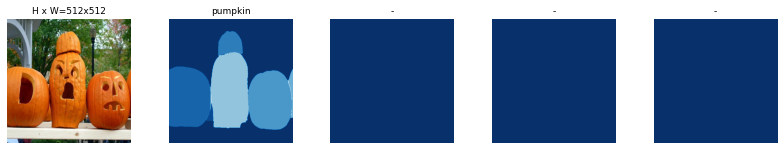

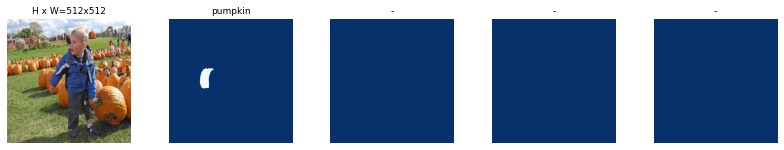

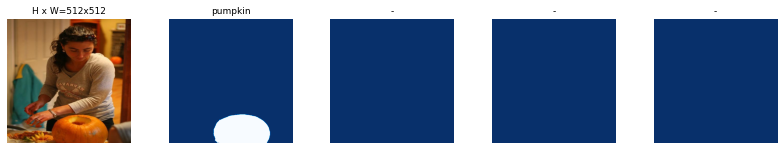

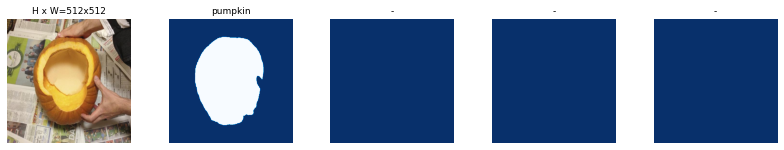

In [10]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create Mask-RCNN model and initialize its weights with COCO dataset

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
init_with = "coco"
# using coco weights
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

## Training  the model

I trained this model in 2 separate stages:



1. First, we train what is called 'heads', the neurons that initialized randomly and didn't have pre-trained weights; we can do this by passing the `layers='heads'` parameter to the train function. In other words, I froze the backbone and just trained the head.


2. This step is optional. I fine-tuned all the layers to make predictions better, and the train heads a bit more; you can perform this step by passing the `layers=all` parameter to the train function.



In [13]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')

end_train = time.time()

minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: ../Semantic-Segmentation\logs\pumpkin20210327T1051\mask_rcnn_pumpkin_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_decon

In [14]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

history_fine_tune = model.keras_model.history.history


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../Semantic-Segmentation\logs\pumpkin20210327T1051\mask_rcnn_pumpkin_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

500/500 [==============================] - 344s 643ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.3327 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3624 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1335 - val_loss: 2.0764 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.5633 - val_mrcnn_class_loss: 0.1482 - val_mrcnn_bbox_loss: 0.1170 - val_mrcnn_mask_loss: 0.1998
Epoch 6/8
500/500 [==============================] - 327s 654ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.2084 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3082 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1317 - val_loss: 1.5099 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.3736 - val_mrcnn_class_loss: 0.1492 - val_mrcnn_bbox_loss: 0.0857 - val_mrcnn_mask_loss: 0.1367
Epoch 7/8
500/500 [==============================] - 333s 665ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.8671 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1891 - mrcnn_class_loss: 

## Test the model

I changed the configuration according to my needs and created a model that uses the weights logged from the training process.

In [15]:
class InferenceConfig(PumpkinsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [16]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [17]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../Semantic-Segmentation\logs\pumpkins20210325T1025\mask_rcnn_pumpkins_0008.h5
Re-starting from epoch 8


# Run Inference


At last, you pass the test images and see how the model performs on unseen data. It seems pretty good :) 

Processing 1 images
image                    shape: (789, 564, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  789.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


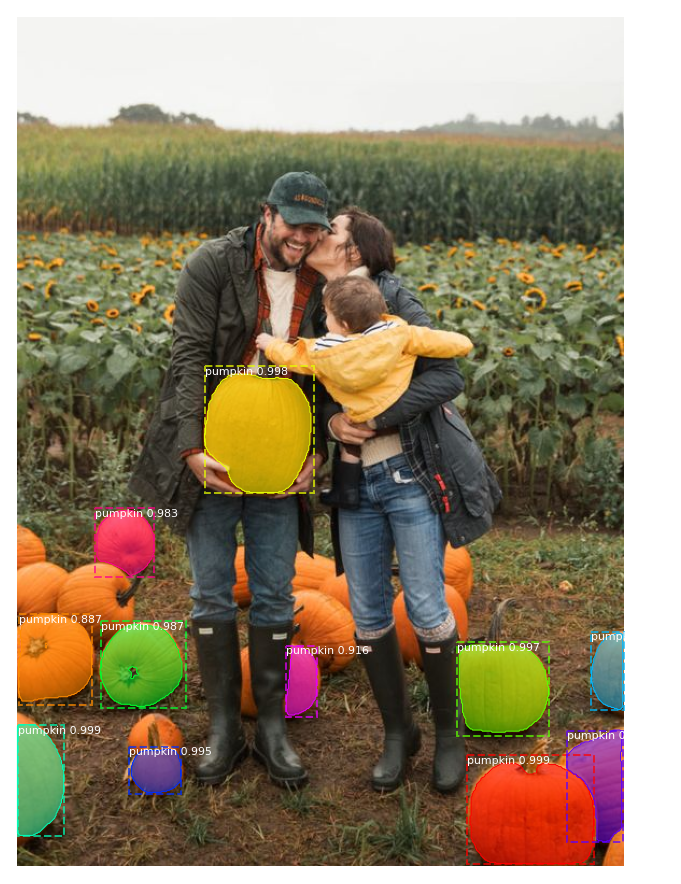

Processing 1 images
image                    shape: (844, 564, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  844.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


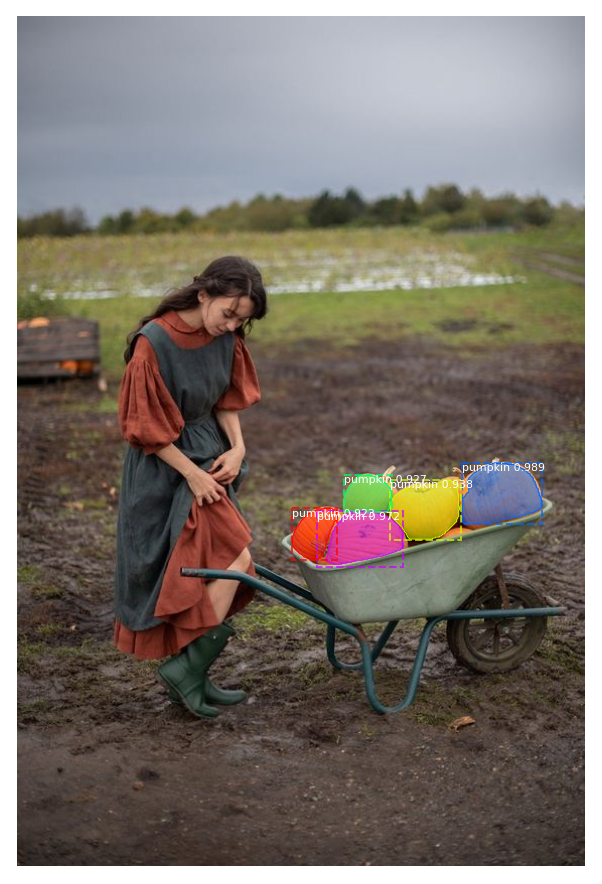

Processing 1 images
image                    shape: (976, 1450, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1450.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


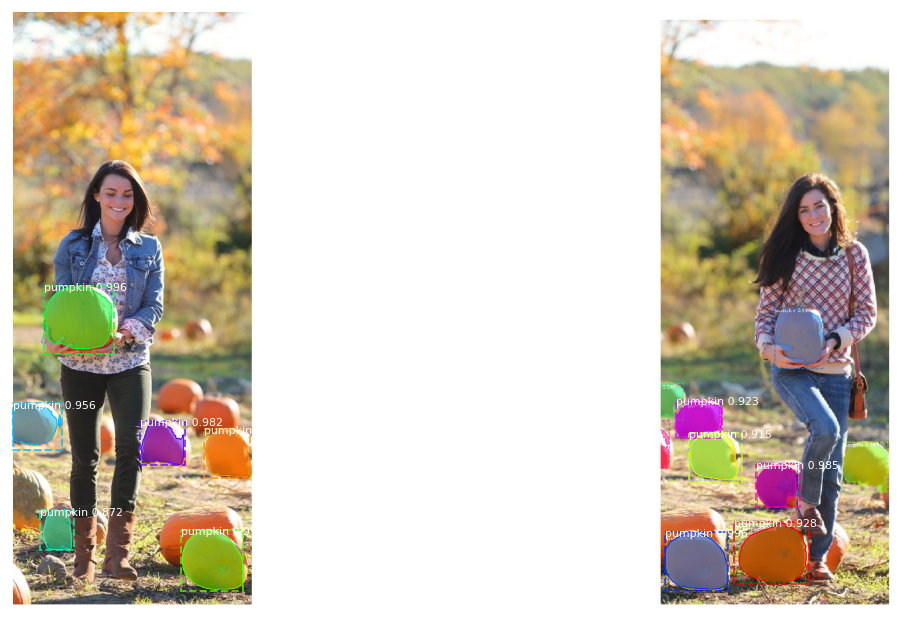

Processing 1 images
image                    shape: (533, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  800.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


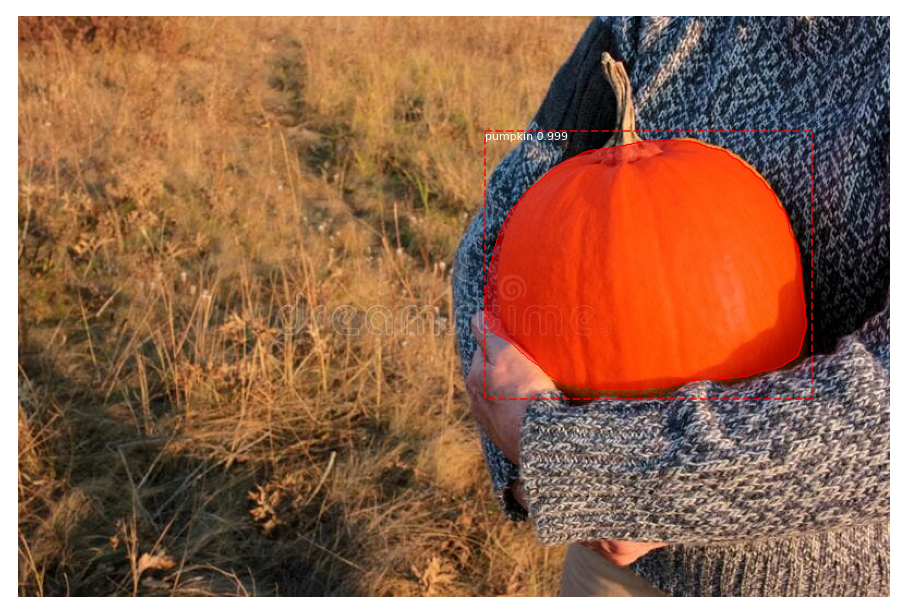

Processing 1 images
image                    shape: (1507, 815, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1507.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


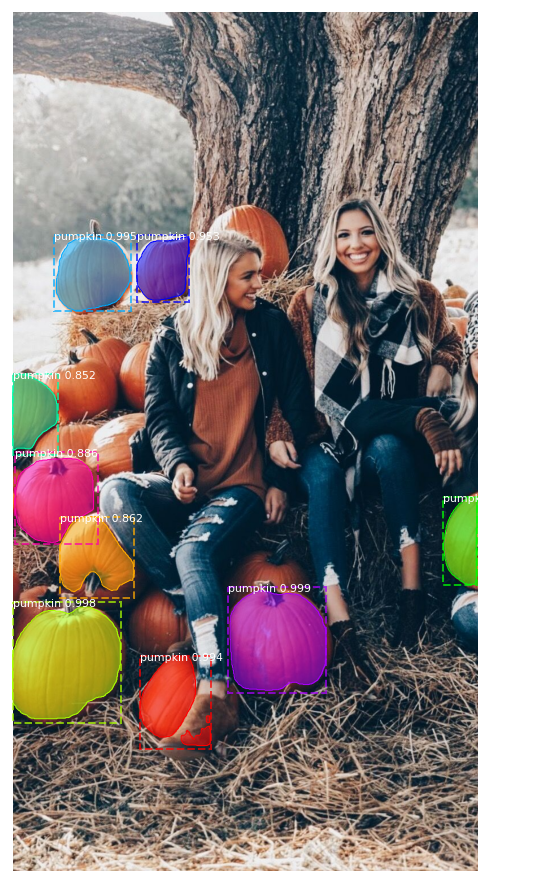

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


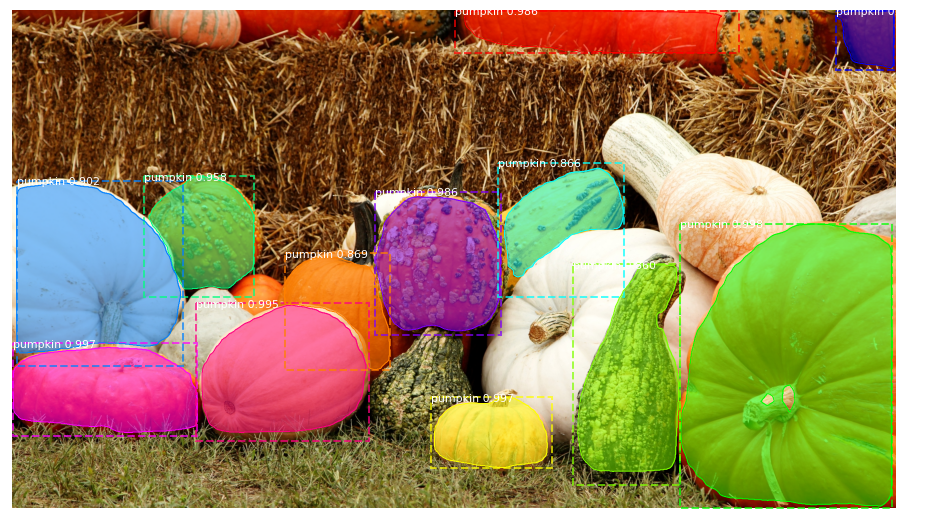

Processing 1 images
image                    shape: (409, 615, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  615.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


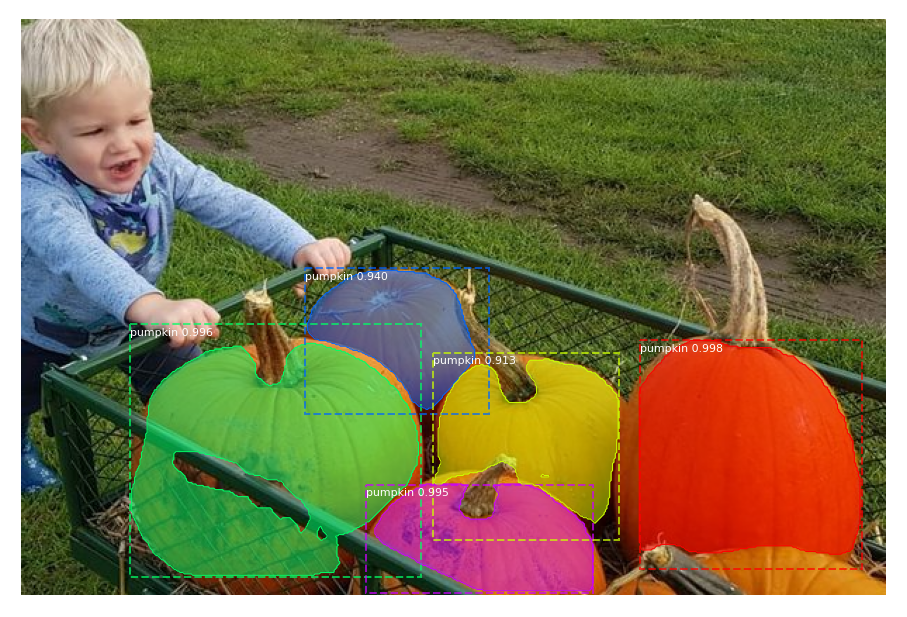

Processing 1 images
image                    shape: (717, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  717.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


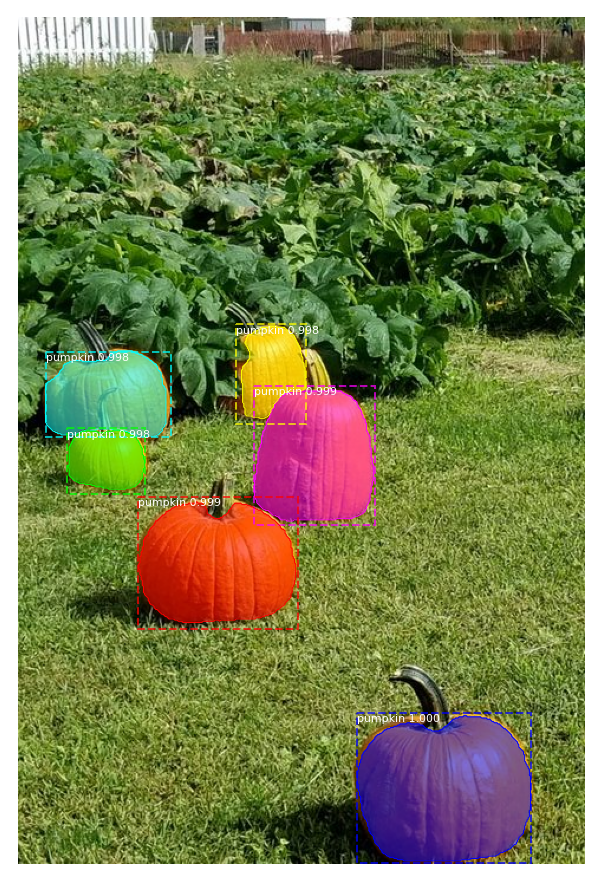

In [18]:
real_test_dir = 'path_to_directory\\test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16,16))
